In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, BisectingKMeans
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, normalized_mutual_info_score, silhouette_samples
)

np.random.seed(0)
RANDOM_STATE = 0
FILE_PATH = "magic04.data.csv"
COLUMNS = ["fLength","fWidth","fSize","fConc","fConc1","fAsym","fM3Long","fM3Trans","fAlpha","fDist","class"]

df = pd.read_csv(FILE_PATH, header=None, names=COLUMNS)
X = df.drop(columns=["class"]).values
y = df["class"].values


(19020, 11)
fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64


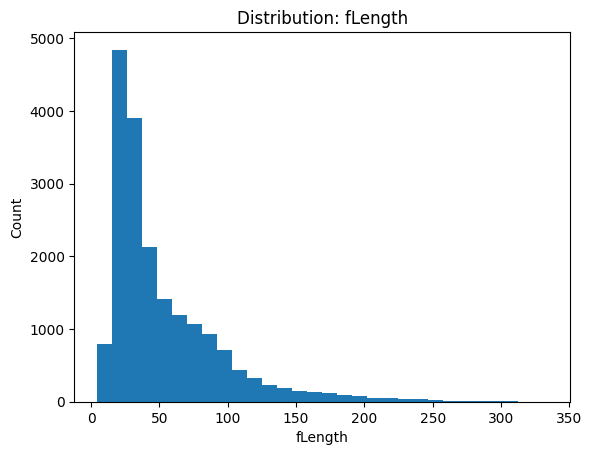

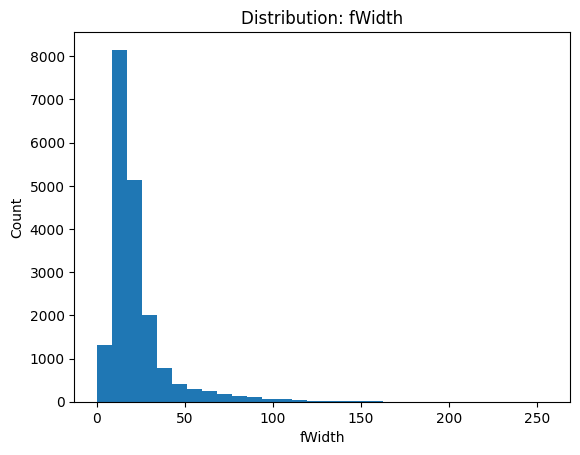

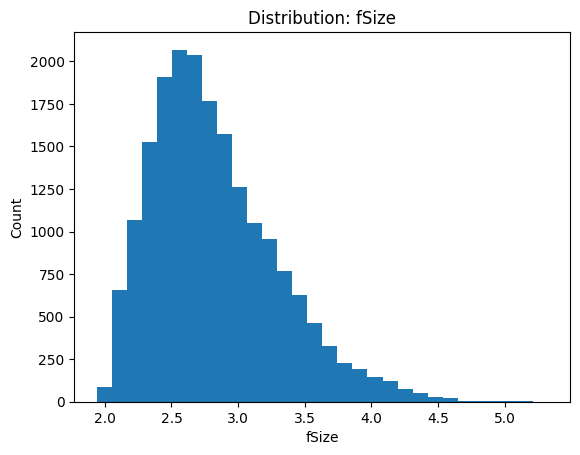

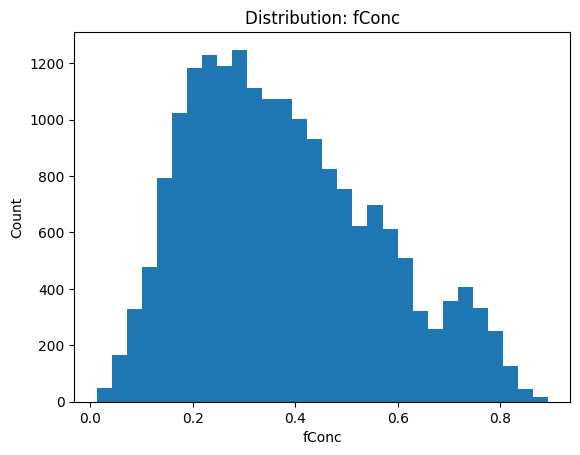

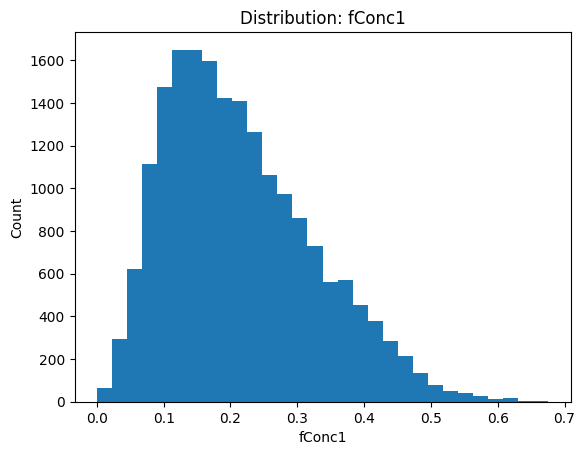

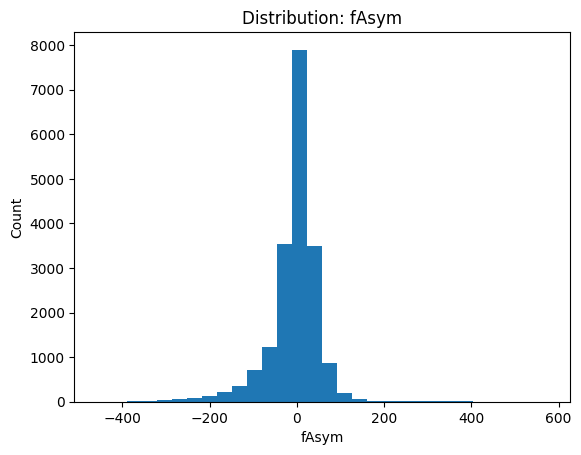

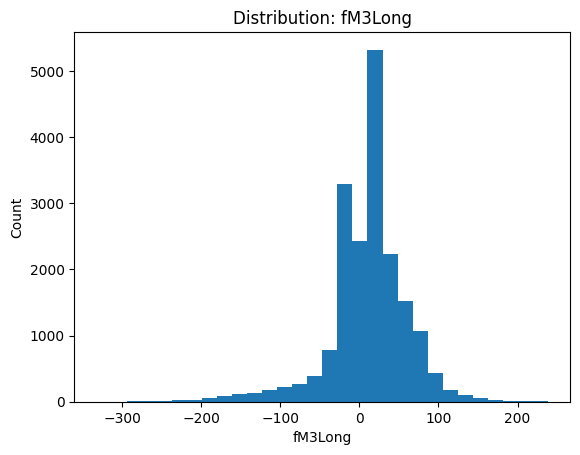

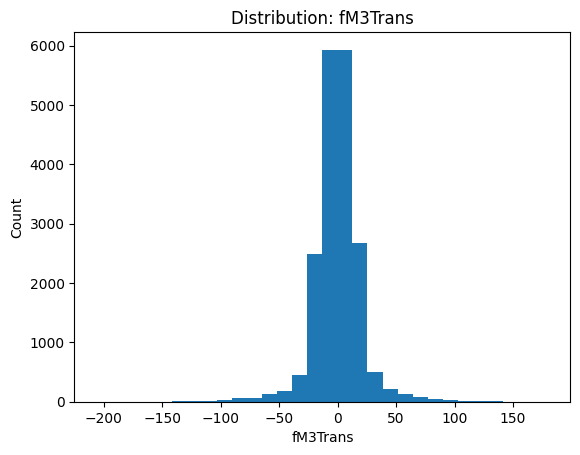

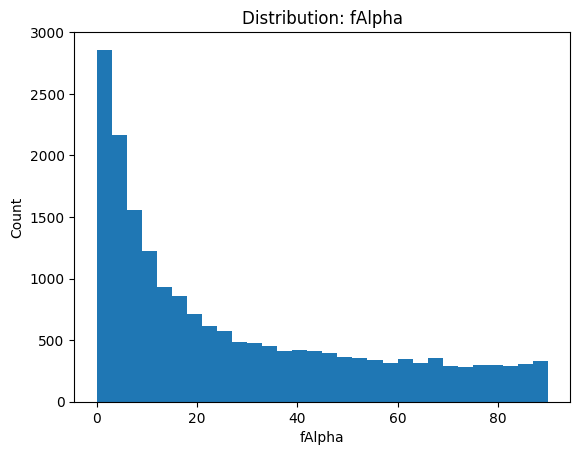

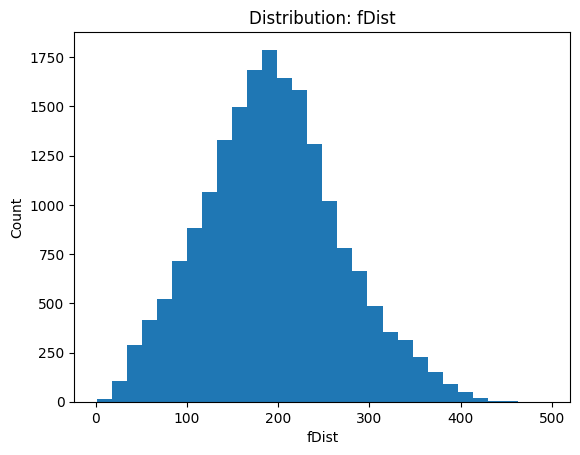

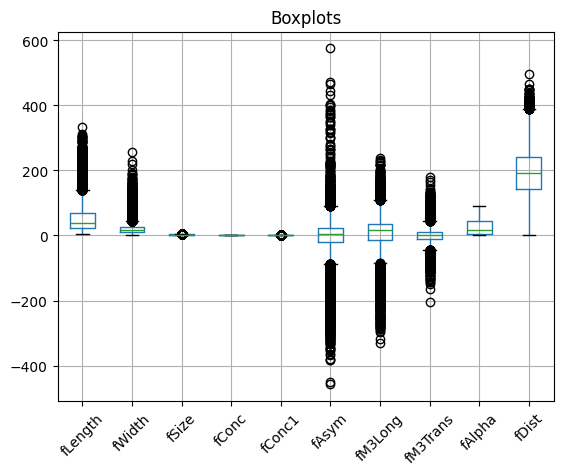

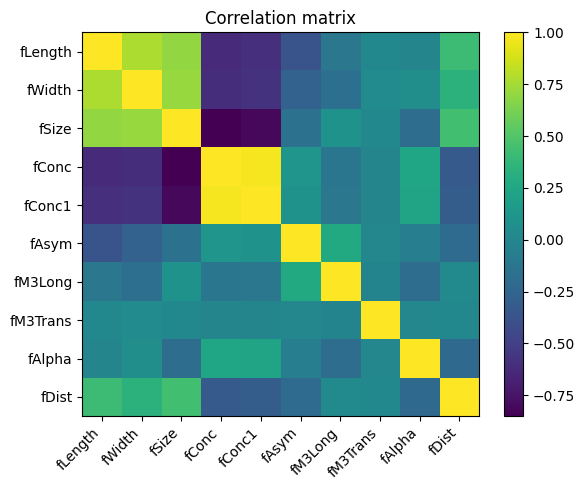

In [12]:
print(df.shape)
print(df.isna().sum())

for col in df.drop(columns="class").columns:
    plt.figure()
    plt.hist(df[col].values, bins=30)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.show()

plt.figure()
df.drop(columns="class").boxplot(rot=45)
plt.title("Boxplots")
plt.show()

corr = df.drop(columns="class").corr().values
plt.figure(figsize=(6,5))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(10), df.drop(columns="class").columns, rotation=45, ha="right")
plt.yticks(range(10), df.drop(columns="class").columns)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()


In [13]:
scaler = StandardScaler()
Xz = scaler.fit_transform(df.drop(columns="class"))

X_red = df.drop(columns=["class","fConc1"])
Xz_red = StandardScaler().fit_transform(X_red)

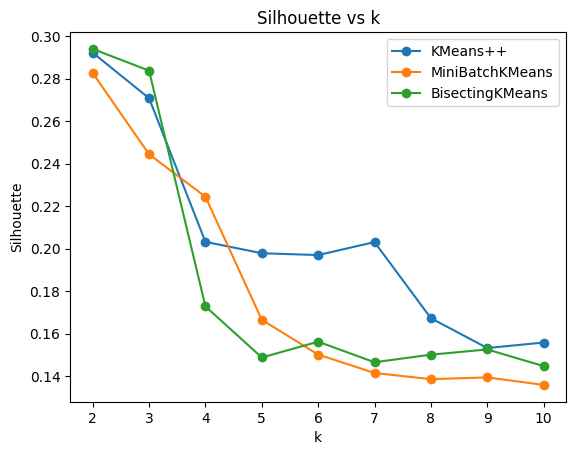

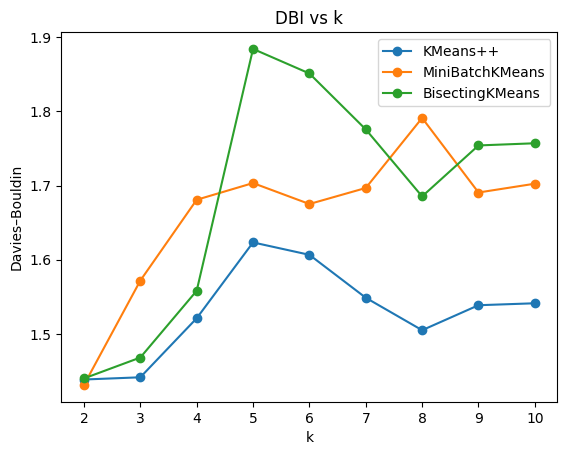

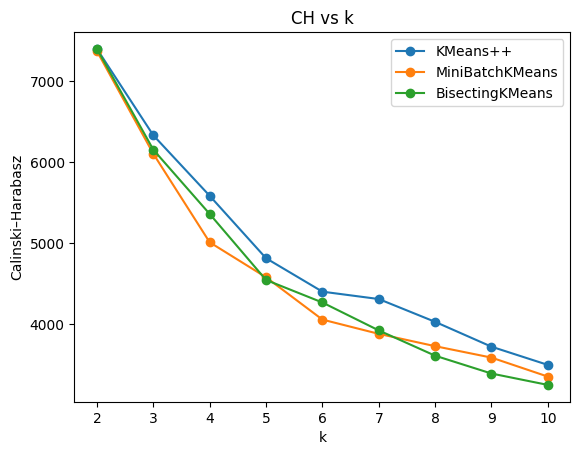

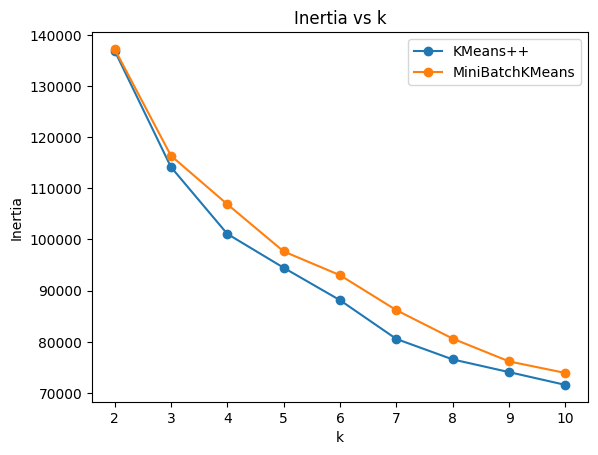

,variante,k,silhouette,DBI,CH
2,BisectingKMeans,2,0.293990,1.440049,7399.214643
0,KMeans++,2,0.292194,1.438588,7399.014188
1,MiniBatchKMeans,2,0.282641,1.431297,7371.877854


In [14]:
def make_kmeans(k):
    return KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=RANDOM_STATE)

def make_minibatch(k):
    return MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE)

def make_bisecting(k):
    return BisectingKMeans(n_clusters=k, random_state=RANDOM_STATE)

constructeurs = {
    "KMeans++": make_kmeans,
    "MiniBatchKMeans": make_minibatch,
    "BisectingKMeans": make_bisecting
}

def evaluer(ctor, Xin, ks):
    rows = []
    for k in ks:
        model = ctor(k)
        labels = model.fit_predict(Xin)
        sil = silhouette_score(Xin, labels)
        dbi = davies_bouldin_score(Xin, labels)
        ch  = calinski_harabasz_score(Xin, labels)
        inertia = getattr(model, "inertia_", np.nan)
        rows.append({"variante":ctor.__name__, "k":k, "silhouette":sil, "DBI":dbi, "CH":ch, "inertia":inertia})
    return pd.DataFrame(rows)

ks = range(2, 11)
scores = {}
for name, ctor in constructeurs.items():
    df_scores = evaluer(ctor, Xz, ks)
    df_scores["variante"] = name
    scores[name] = df_scores

scores_all = pd.concat(scores.values(), ignore_index=True)

plt.figure()
for name in constructeurs.keys():
    d = scores[name]
    plt.plot(d["k"], d["silhouette"], marker="o", label=name)
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette vs k")
plt.legend(); plt.show()

plt.figure()
for name in constructeurs.keys():
    d = scores[name]
    plt.plot(d["k"], d["DBI"], marker="o", label=name)
plt.xlabel("k"); plt.ylabel("Davies–Bouldin"); plt.title("DBI vs k")
plt.legend(); plt.show()

plt.figure()
for name in constructeurs.keys():
    d = scores[name]
    plt.plot(d["k"], d["CH"], marker="o", label=name)
plt.xlabel("k"); plt.ylabel("Calinski–Harabasz"); plt.title("CH vs k")
plt.legend(); plt.show()

plt.figure()
for name in ["KMeans++","MiniBatchKMeans"]:
    d = scores[name]
    plt.plot(d["k"], d["inertia"], marker="o", label=name)
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Inertia vs k")
plt.legend(); plt.show()

def choisir_k(df_scores):
    best = df_scores.sort_values(by=["silhouette","DBI","CH"], ascending=[False, True, False]).iloc[0]
    return int(best["k"]), best

best_rows = []
for name in constructeurs.keys():
    k_star, row = choisir_k(scores[name])
    best_rows.append({"variante":name, "k":k_star, "silhouette":row["silhouette"], "DBI":row["DBI"], "CH":row["CH"]})
best_by_variant = pd.DataFrame(best_rows).sort_values(by=["silhouette","DBI","CH"], ascending=[False, True, False])
best_by_variant


In [15]:
best_variant = best_by_variant.iloc[0]["variante"]
best_k = int(best_by_variant.iloc[0]["k"])

if best_variant == "KMeans++":
    best_model = KMeans(n_clusters=best_k, init="k-means++", n_init="auto", random_state=RANDOM_STATE).fit(Xz)
elif best_variant == "MiniBatchKMeans":
    best_model = MiniBatchKMeans(n_clusters=best_k, random_state=RANDOM_STATE).fit(Xz)
else:
    best_model = BisectingKMeans(n_clusters=best_k, random_state=RANDOM_STATE).fit(Xz)

labels_best = best_model.labels_

kmeans_random = KMeans(n_clusters=best_k, init="random", n_init=10, random_state=RANDOM_STATE).fit(Xz)
labels_random = kmeans_random.labels_

def purity_score(y_true, y_pred):
    ctab = pd.crosstab(y_pred, y_true)
    return np.sum(np.max(ctab.values, axis=1)) / np.sum(ctab.values)

def internes(Xin, labels, model):
    return {
        "Silhouette": silhouette_score(Xin, labels),
        "DBI": davies_bouldin_score(Xin, labels),
        "CH": calinski_harabasz_score(Xin, labels),
        "Inertia": getattr(model, "inertia_", np.nan)
    }

def externes(y_true, labels):
    return {
        "Purity": purity_score(y_true, labels),
        "ARI": adjusted_rand_score(y_true, labels),
        "NMI": normalized_mutual_info_score(y_true, labels)
    }

res_best = {**internes(Xz, labels_best, best_model), **externes(y, labels_best)}
res_rand = {**internes(Xz, labels_random, kmeans_random), **externes(y, labels_random)}
pd.DataFrame([res_best, res_rand], index=[f"{best_variant} (k={best_k})", f"KMeans random (k={best_k})"])


,Silhouette,DBI,CH,Inertia,Purity,ARI,NMI
BisectingKMeans (k=2),0.29399,1.440049,7399.214643,136927.135141,0.64837,0.006518,0.001553
KMeans random (k=2),0.29399,1.440049,7399.214643,136927.135141,0.64837,0.006518,0.001553


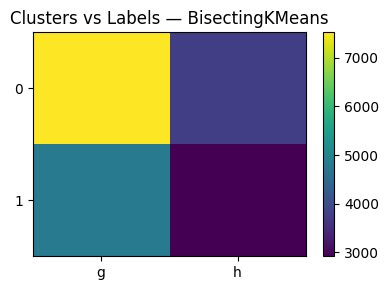

In [16]:
ctab_best = pd.crosstab(labels_best, y)
plt.figure(figsize=(4,3))
plt.imshow(ctab_best, aspect="auto")
plt.colorbar()
plt.xticks(range(len(ctab_best.columns)), ctab_best.columns)
plt.yticks(range(len(ctab_best.index)), ctab_best.index)
plt.title(f"Clusters vs Labels — {best_variant}")
plt.tight_layout()
plt.show()

Nombre de composantes retenues (95% variance): 7
                                  Silhouette       DBI           CH  \
BisectingKMeans (données brutes)    0.293990  1.440049  7399.214643   
BisectingKMeans (PCA95)             0.303027  1.398490  7820.136241   

                                        Inertia   Purity       ARI       NMI  
BisectingKMeans (données brutes)  136927.135141  0.64837  0.006518  0.001553  
BisectingKMeans (PCA95)           129450.819796  0.64837  0.006220  0.001446  


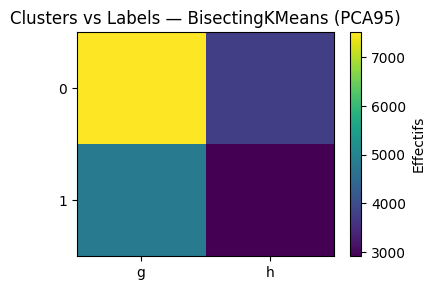

In [ ]:
pca95 = PCA(n_components=0.95, random_state=RANDOM_STATE).fit(Xz)
X_pca95 = pca95.transform(Xz)
print("Nombre de composantes retenues (95% variance):", pca95.n_components_)

# Relancer le meilleur modèle sur PCA95
if best_variant == "KMeans++":
    best_pca95 = KMeans(n_clusters=best_k, init="k-means++", n_init="auto", random_state=RANDOM_STATE).fit(X_pca95)
elif best_variant == "MiniBatchKMeans":
    best_pca95 = MiniBatchKMeans(n_clusters=best_k, random_state=RANDOM_STATE).fit(X_pca95)
else:
    best_pca95 = BisectingKMeans(n_clusters=best_k, random_state=RANDOM_STATE).fit(X_pca95)

labels_pca95 = best_pca95.labels_

# Évaluation interne
res_pca95 = {**internes(X_pca95, labels_pca95, best_pca95), **externes(y, labels_pca95)}

# Résultats comparés : PCA95 vs données brutes
res_compare = pd.DataFrame([res_best, res_pca95], 
                           index=[f"{best_variant} (données brutes)", f"{best_variant} (PCA95)"])
print(res_compare)

# Matrice clusters vs labels
ctab_pca95 = pd.crosstab(labels_pca95, y)
plt.figure(figsize=(4,3))
plt.imshow(ctab_pca95, aspect="auto", cmap="viridis")
plt.colorbar(label="Effectifs")
plt.xticks(range(len(ctab_pca95.columns)), ctab_pca95.columns)
plt.yticks(range(len(ctab_pca95.index)), ctab_pca95.index)
plt.title(f"Clusters vs Labels — {best_variant} (PCA95)")
plt.tight_layout()
plt.show()


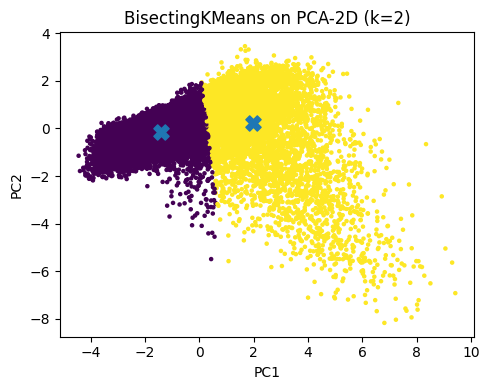

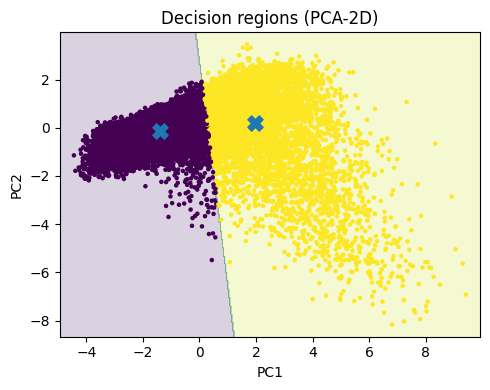

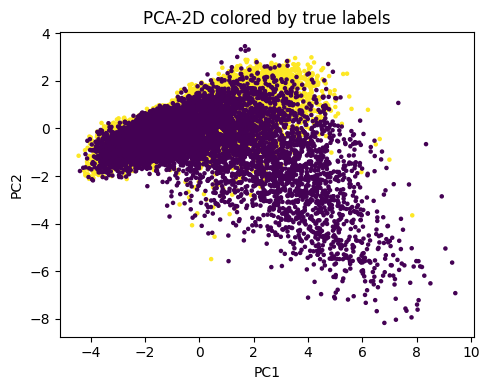

In [17]:
pca2 = PCA(n_components=2, random_state=RANDOM_STATE).fit(Xz)
X_pca2 = pca2.transform(Xz)

if best_variant == "KMeans++":
    best_2d = KMeans(n_clusters=best_k, init="k-means++", n_init="auto", random_state=RANDOM_STATE).fit(X_pca2)
elif best_variant == "MiniBatchKMeans":
    best_2d = MiniBatchKMeans(n_clusters=best_k, random_state=RANDOM_STATE).fit(X_pca2)
else:
    best_2d = BisectingKMeans(n_clusters=best_k, random_state=RANDOM_STATE).fit(X_pca2)

lab_2d = best_2d.labels_
centers_2d = getattr(best_2d, "cluster_centers_", None)

plt.figure(figsize=(5,4))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=5, c=lab_2d)
if centers_2d is not None:
    plt.scatter(centers_2d[:,0], centers_2d[:,1], s=120, marker="X")
plt.title(f"{best_variant} on PCA-2D (k={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

x_min, x_max = X_pca2[:,0].min()-0.5, X_pca2[:,0].max()+0.5
y_min, y_max = X_pca2[:,1].min()-0.5, X_pca2[:,1].max()+0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
Z = best_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(5,4))
plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=5, c=lab_2d)
if centers_2d is not None:
    plt.scatter(centers_2d[:,0], centers_2d[:,1], s=120, marker="X")
plt.title("Decision regions (PCA-2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

lab_true = (y == "g").astype(int)
plt.figure(figsize=(5,4))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=5, c=lab_true)
plt.title("PCA-2D colored by true labels")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()


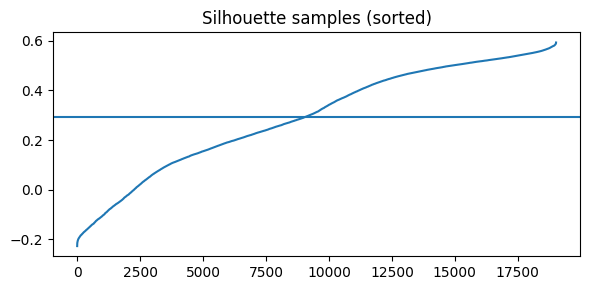

In [18]:
sil_vals = silhouette_samples(Xz, labels_best)
order = np.argsort(sil_vals)
vals_sorted = sil_vals[order]
plt.figure(figsize=(6,3))
plt.plot(vals_sorted)
plt.axhline(np.mean(sil_vals))
plt.title("Silhouette samples (sorted)")
plt.tight_layout()
plt.show()


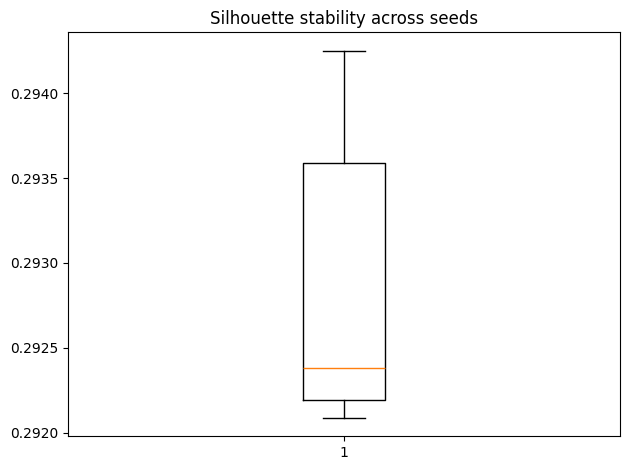

In [19]:
seeds = list(range(10))
sil_by_seed = []
for s in seeds:
    if best_variant == "KMeans++":
        m = KMeans(n_clusters=best_k, init="k-means++", n_init=1, random_state=s).fit(Xz)
    elif best_variant == "MiniBatchKMeans":
        m = MiniBatchKMeans(n_clusters=best_k, random_state=s).fit(Xz)
    else:
        m = BisectingKMeans(n_clusters=best_k, random_state=s).fit(Xz)
    sil_by_seed.append(silhouette_score(Xz, m.labels_))

plt.figure()
plt.boxplot(sil_by_seed, vert=True)
plt.title("Silhouette stability across seeds")
plt.tight_layout()
plt.show()


In [20]:
df_clusters = df.copy()
df_clusters["cluster"] = labels_best
profile = df_clusters.groupby("cluster").mean(numeric_only=True)
profile


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
cluster,,,,,,,,,,
0,29.655249,13.519667,2.522654,0.492315,0.279582,4.716555,4.828585,-0.024013,33.091027,162.501463
1,87.704026,34.828412,3.266535,0.216799,0.119852,-17.544301,18.893593,0.649446,19.694314,239.547257


In [21]:
resume = {
    "BestVariant": best_variant,
    "k": best_k,
    "Silhouette": res_best["Silhouette"],
    "DBI": res_best["DBI"],
    "CH": res_best["CH"],
    "Purity": res_best["Purity"],
    "ARI": res_best["ARI"],
    "NMI": res_best["NMI"]
}
pd.DataFrame([resume])


,BestVariant,k,Silhouette,DBI,CH,Purity,ARI,NMI
0,BisectingKMeans,2,0.29399,1.440049,7399.214643,0.64837,0.006518,0.001553
